# Project Setup
	- Import Python libraries
	- Connect to SQL Database
	- Load Datasets

In [1]:
import os
from dotenv import load_dotenv
import pyodbc
import pandas as pd
from pathlib import Path
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load environment variables
load_dotenv()

# Read values
server = os.getenv("DB_SERVER")
port = os.getenv("DB_PORT", "1433")  # Default SQL Server port
database = os.getenv("DB_NAME")
username = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")

# Create connection string
connection_string = f"mssql+pyodbc://{username}:{password}@{server}:{port}/{database}?driver=ODBC+Driver+17+for+SQL+Server"

# Connect
conn = create_engine(connection_string)

# Define load_query function to load SQL queries from files
def load_query(name):
	path = Path("../sql") / f"{name}.sql"
	if not path.exists():
		raise FileNotFoundError(f"Query file {path} does not exist.")
	return path.read_text()

In [3]:
# Load contracts data
contracts_df = pd.read_sql(load_query('get_contracts'), conn)
contracts_df

,contract_id,supplier_id,contract_value_million,contract_type,award_date,expected_duration_months,status
0,CTR00000,SUP0056,1.75,R&D,2025-03-30,37,delayed
1,CTR00001,SUP0087,6.18,Tech Services,2021-07-14,25,terminated
2,CTR00002,SUP0224,2.95,R&D,2024-12-04,15,terminated
3,CTR00003,SUP0104,0.23,Production,2022-06-15,34,terminated
4,CTR00004,SUP0252,0.13,Production,2024-05-14,46,delayed
...,...,...,...,...,...,...,...
4995,CTR04995,SUP0030,8.05,R&D,2022-11-04,11,completed
4996,CTR04996,SUP0296,3.46,Production,2023-12-18,14,completed
4997,CTR04997,SUP0095,2.02,Production,2020-06-03,26,completed
4998,CTR04998,SUP0270,0.14,Sustainment,2020-07-18,17,delayed


In [4]:
# Load suppliers data
suppliers_df = pd.read_sql(load_query('get_suppliers'), conn)
suppliers_df

,supplier_id,supplier_name,past_contracts,average_delay_days,compliance_issues
0,SUP0003,Wiley-Moore,19,1,1
1,SUP0005,"Liu, Jones and Jones",17,142,3
2,SUP0006,Page LLC,30,163,1
3,SUP0008,Potter PLC,29,8,0
4,SUP0011,Rogers and Sons,28,92,2
...,...,...,...,...,...
310,SUP0492,Garza-Hamilton,33,68,1
311,SUP0497,Murphy Group,7,35,2
312,SUP0498,"Pierce, Willis and Melendez",4,45,4
313,SUP0499,Bush and Sons,16,110,3


In [5]:
# Load delays data
delays_df = pd.read_sql(load_query('get_delays'), conn)
delays_df

,contract_id,supplier_id,contract_value_million,contract_type,award_date,expected_duration_months,status,delay_days
0,CTR00000,SUP0056,1.75,R&D,2025-03-30,37,delayed,153
1,CTR00004,SUP0252,0.13,Production,2024-05-14,46,delayed,99
2,CTR00005,SUP0374,0.50,Sustainment,2021-12-28,57,delayed,99
3,CTR00012,SUP0116,3.08,R&D,2022-07-17,12,delayed,149
4,CTR00013,SUP0395,4.53,Production,2021-05-03,11,delayed,31
...,...,...,...,...,...,...,...,...
1264,CTR04977,SUP0344,2.77,R&D,2024-12-30,43,delayed,104
1265,CTR04989,SUP0194,1.24,Production,2020-09-23,51,delayed,223
1266,CTR04992,SUP0222,1.27,Production,2021-01-20,33,delayed,121
1267,CTR04994,SUP0337,1.26,Tech Services,2023-02-07,41,delayed,194


# Data Preparation
	- Dataset Overview
	- Merge datasets
	- Feature Engineering

In [6]:
# Dataset Overview
print("Contracts Data Overview:")
contracts_df.info()
print("\nSuppliers Data Overview:")
suppliers_df.info()
print("\nDelays Data Overview:")
delays_df.info()

Contracts Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   contract_id               5000 non-null   object 
 1   supplier_id               5000 non-null   object 
 2   contract_value_million    5000 non-null   float64
 3   contract_type             5000 non-null   object 
 4   award_date                5000 non-null   object 
 5   expected_duration_months  5000 non-null   int64  
 6   status                    5000 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 273.6+ KB

Suppliers Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   supplier_id         315 non-null    object
 1   supplier_name       315 non-nul

In [7]:
# Merge contracts and suppliers data
merged_df = pd.merge(contracts_df, suppliers_df, on='supplier_id')

# Select delayed contracts
merged_df = pd.merge(merged_df, delays_df[['contract_id', 'delay_days']], on='contract_id')
merged_df


,contract_id,supplier_id,contract_value_million,contract_type,award_date,expected_duration_months,status,supplier_name,past_contracts,average_delay_days,compliance_issues,delay_days
0,CTR00004,SUP0252,0.13,Production,2024-05-14,46,delayed,Powell-Bowman,41,152,0,99
1,CTR00005,SUP0374,0.50,Sustainment,2021-12-28,57,delayed,"Shah, Watson and Smith",3,186,4,99
2,CTR00012,SUP0116,3.08,R&D,2022-07-17,12,delayed,Conway Ltd,11,83,0,149
3,CTR00013,SUP0395,4.53,Production,2021-05-03,11,delayed,"Williams, Galvan and Peterson",34,170,2,31
4,CTR00016,SUP0456,0.97,Tech Services,2025-01-19,23,delayed,Thompson-Rogers,48,64,1,62
...,...,...,...,...,...,...,...,...,...,...,...,...
786,CTR04956,SUP0473,7.04,R&D,2020-11-22,24,delayed,Hunter-Weeks,8,178,0,181
787,CTR04972,SUP0499,0.01,Production,2024-09-01,16,delayed,Bush and Sons,16,110,3,19
788,CTR04974,SUP0058,2.56,Sustainment,2025-03-07,37,delayed,"Wilson, Sullivan and Calhoun",39,91,4,135
789,CTR04992,SUP0222,1.27,Production,2021-01-20,33,delayed,"Miller, Campbell and Johnson",27,21,1,121


## Feature Engineering
	- Contract Age (Today - Award Date)
	- Contract Value per month (Contract Value / Expected Duration Months)
	- Risk Score (60% Delay + 40% Compliance Issues)

In [ ]:
# Calculate contract age
merged_df['award_date'] = pd.to_datetime(merged_df['award_date'])
merged_df['contract_age_days'] = (pd.to_datetime('today') - merged_df['award_date']).dt.days
merged_df['contract_age_months'] = merged_df['contract_age_days'] // 30

# Calculate value per month
merged_df['value_per_month'] = merged_df['contract_value_million'] / merged_df['expected_duration_months']

# Replace infinite values and NaNs in value_per_month
merged_df['value_per_month'] = merged_df['value_per_month'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Normalize delay_days and compliance_issues
merged_df['normalized_delay'] = (merged_df['delay_days'] - merged_df['delay_days'].min()) / (merged_df['delay_days'].max() - merged_df['delay_days'].min())
merged_df['normalized_compliance'] = (merged_df['compliance_issues'] - merged_df['compliance_issues'].min()) / (merged_df['compliance_issues'].max() - merged_df['compliance_issues'].min())

# Calculate risk score (normalized_delay * 0.6 + normalized_compliance * 0.4)
merged_df['risk_score'] = merged_df['normalized_delay'] * 0.6 + merged_df['normalized_compliance'] * 0.4

# Classify risk levels
def classify_risk(score) -> str:
	if score < 0.3:
		return 'Low'
	elif score < 0.7:
		return 'Medium'
	else:
		return 'High'
merged_df['risk_level'] = merged_df['risk_score'].apply(classify_risk)

,contract_id,supplier_id,contract_value_million,contract_type,award_date,expected_duration_months,status,supplier_name,past_contracts,average_delay_days,compliance_issues,delay_days,contract_age_days,contract_age_months,value_per_month,normalized_delay,normalized_compliance,risk_score,risk_level
0,CTR00004,SUP0252,0.13,Production,2024-05-14,46,delayed,Powell-Bowman,41,152,0,99,385,12,0.002826,0.375000,0.00,0.225000,Low
1,CTR00005,SUP0374,0.50,Sustainment,2021-12-28,57,delayed,"Shah, Watson and Smith",3,186,4,99,1253,41,0.008772,0.375000,1.00,0.625000,Medium
2,CTR00012,SUP0116,3.08,R&D,2022-07-17,12,delayed,Conway Ltd,11,83,0,149,1052,35,0.256667,0.598214,0.00,0.358929,Medium
3,CTR00013,SUP0395,4.53,Production,2021-05-03,11,delayed,"Williams, Galvan and Peterson",34,170,2,31,1492,49,0.411818,0.071429,0.50,0.242857,Low
4,CTR00016,SUP0456,0.97,Tech Services,2025-01-19,23,delayed,Thompson-Rogers,48,64,1,62,135,4,0.042174,0.209821,0.25,0.225893,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,CTR04956,SUP0473,7.04,R&D,2020-11-22,24,delayed,Hunter-Weeks,8,178,0,181,1654,55,0.293333,0.741071,0.00,0.444643,Medium
787,CTR04972,SUP0499,0.01,Production,2024-09-01,16,delayed,Bush and Sons,16,110,3,19,275,9,0.000625,0.017857,0.75,0.310714,Medium
788,CTR04974,SUP0058,2.56,Sustainment,2025-03-07,37,delayed,"Wilson, Sullivan and Calhoun",39,91,4,135,88,2,0.069189,0.535714,1.00,0.721429,High
789,CTR04992,SUP0222,1.27,Production,2021-01-20,33,delayed,"Miller, Campbell and Johnson",27,21,1,121,1595,53,0.038485,0.473214,0.25,0.383929,Medium


In [26]:
# Save cleaned dataset to CSV
merged_df.to_csv('../dataset/outputs/cleaned_contracts.csv', index=False)

# Exploratory Data Analysis (EDA)

## Univariate
	- Categorical Variables (Bar Chart, Pie Chart)
	- Numeric Variables (Histogram, Boxplot)

Category counts for contract_type:
contract_type
Production       202
R&D              216
Sustainment      200
Tech Services    173
Name: count, dtype: int64



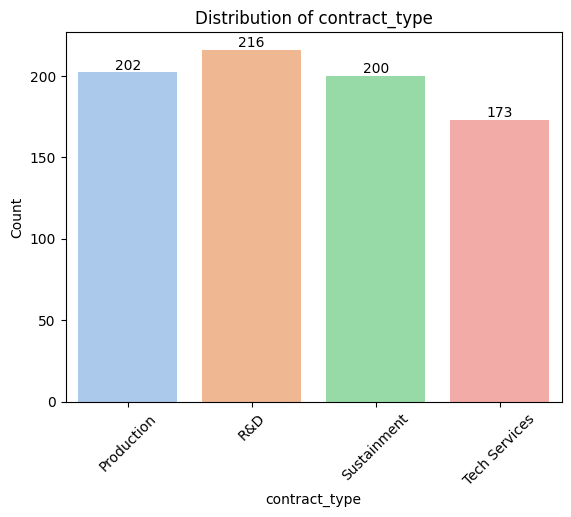

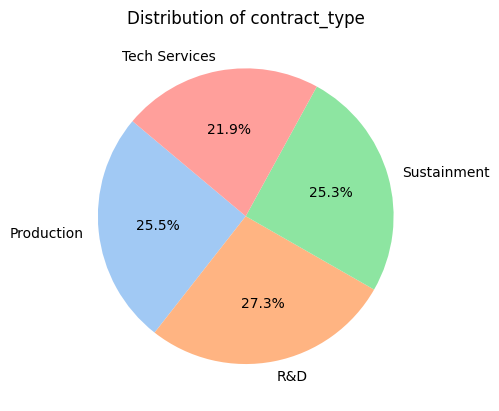

Category counts for compliance_issues:
compliance_issues
0    158
1    184
2    118
3    132
4    199
Name: count, dtype: int64



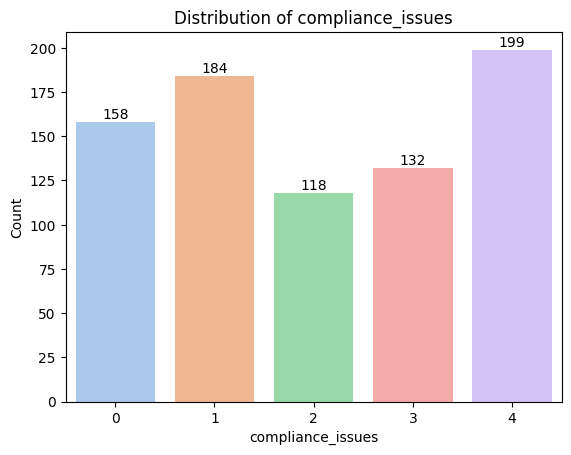

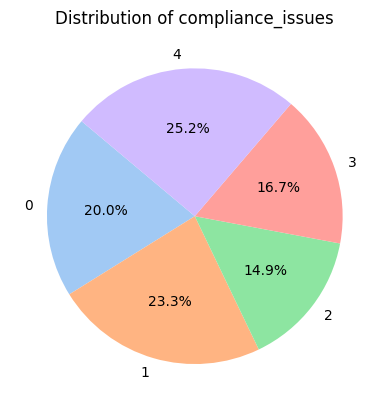

Statistics for contract_value_million: 
count    791.000000
mean       3.528445
std        3.604157
min        0.000000
25%        0.950000
50%        2.440000
75%        4.860000
max       26.370000
Name: contract_value_million, dtype: float64



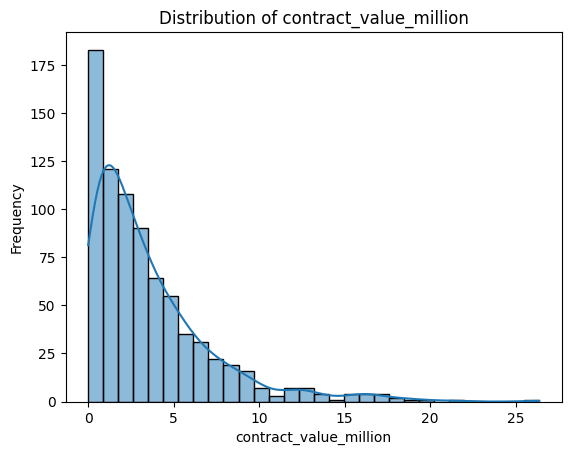

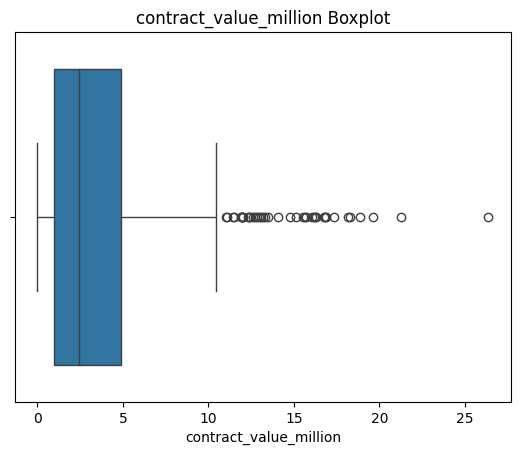

Statistics for expected_duration_months: 
count    791.00000
mean      32.71555
std       15.41900
min        6.00000
25%       20.00000
50%       32.00000
75%       46.00000
max       59.00000
Name: expected_duration_months, dtype: float64



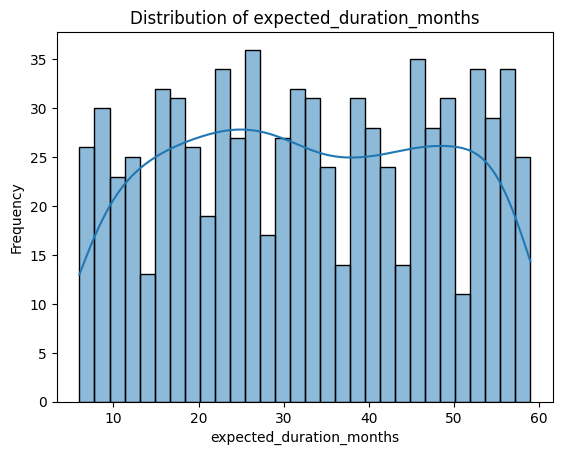

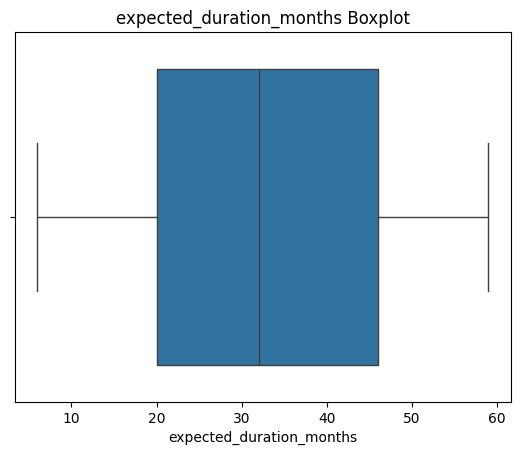

Statistics for average_delay_days: 
count    791.000000
mean      99.441214
std       57.454804
min        0.000000
25%       50.000000
50%       98.000000
75%      151.000000
max      196.000000
Name: average_delay_days, dtype: float64



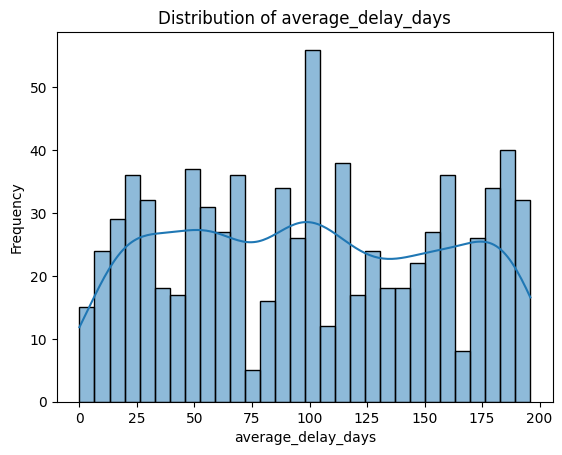

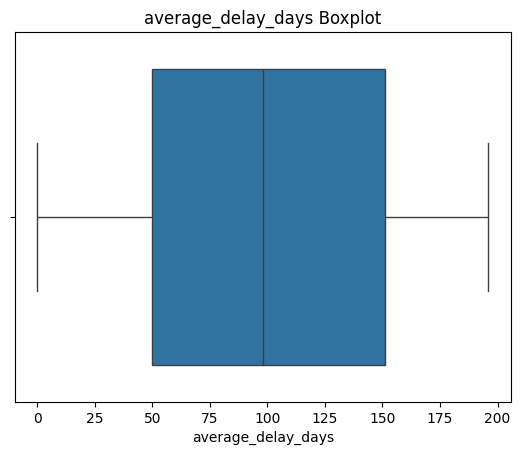

Statistics for delay_days: 
count    791.000000
mean     125.600506
std       66.335070
min       15.000000
25%       69.000000
50%      124.000000
75%      181.000000
max      239.000000
Name: delay_days, dtype: float64



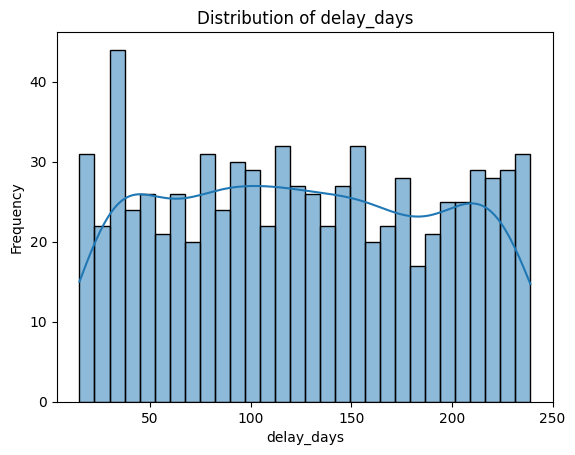

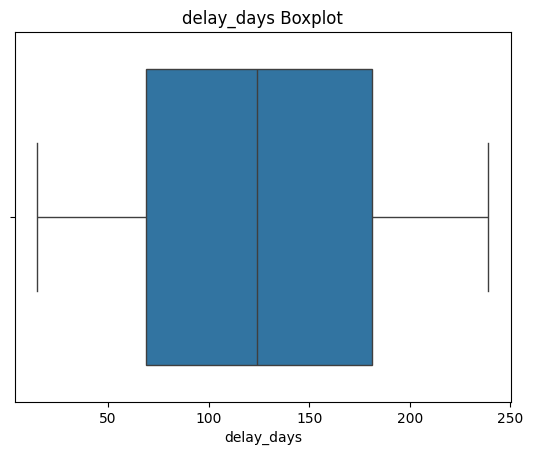

Statistics for risk_score: 
count    791.000000
mean       0.500044
std        0.234129
min        0.000000
25%        0.321875
50%        0.506250
75%        0.668750
max        1.000000
Name: risk_score, dtype: float64



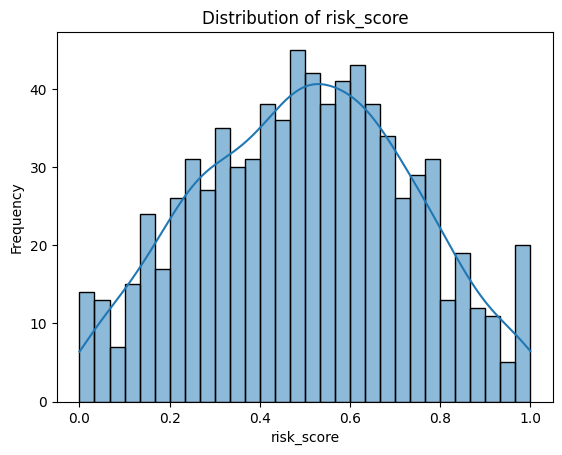

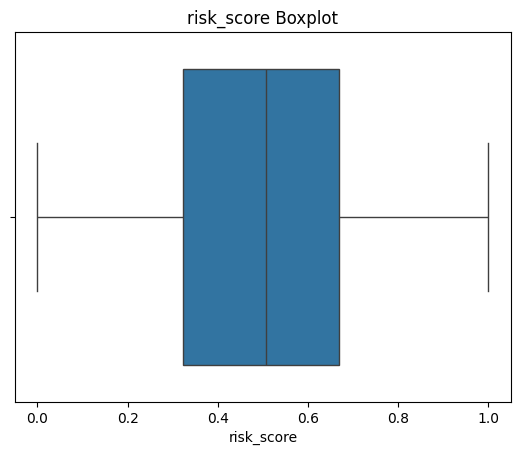

Statistics for value_per_month: 
count    791.000000
mean       0.154736
std        0.238097
min        0.000000
25%        0.030689
50%        0.081304
75%        0.170976
max        2.808333
Name: value_per_month, dtype: float64



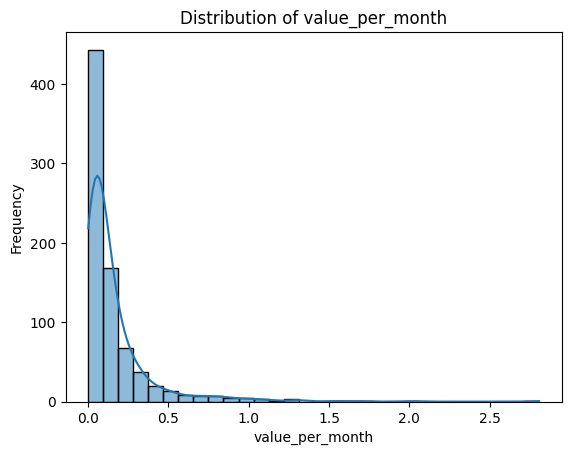

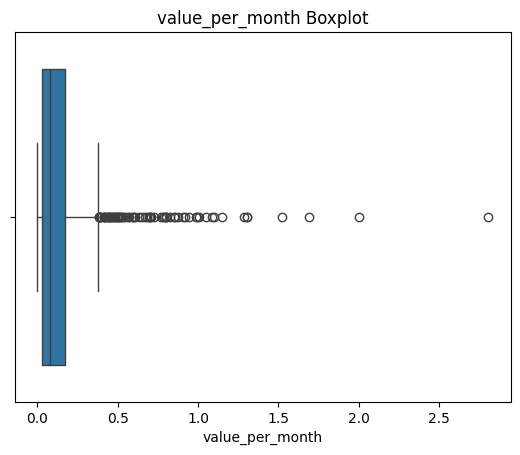

Statistics for contract_age_days: 
count     791.000000
mean      947.761062
std       548.250012
min        22.000000
25%       458.500000
50%       957.000000
75%      1441.500000
max      1847.000000
Name: contract_age_days, dtype: float64



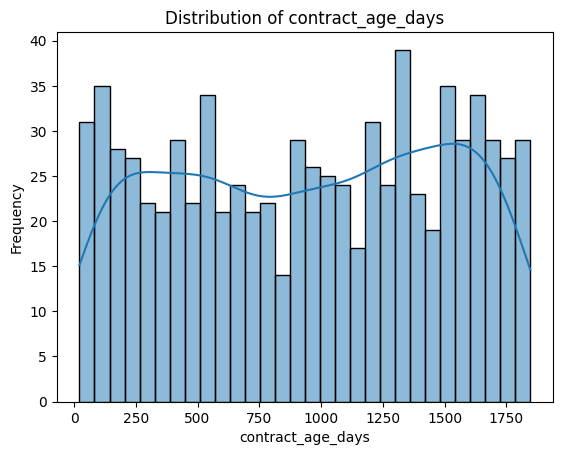

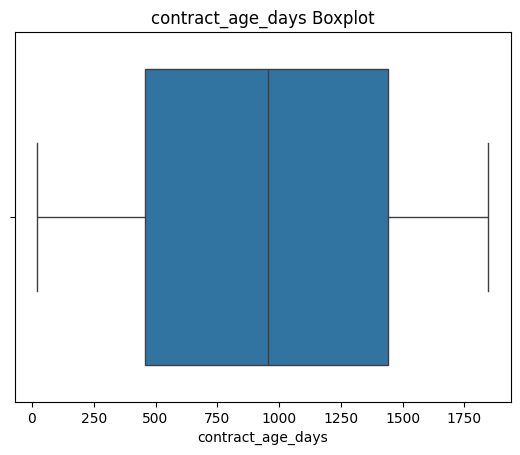

In [23]:
categorical_cols = ['contract_type', 'compliance_issues']
numerical_cols = ['contract_value_million', 'expected_duration_months', 'average_delay_days', 'delay_days', 'risk_score', 'value_per_month', 'contract_age_days']

for col in categorical_cols:
	category_counts = merged_df[col].value_counts().sort_index()
	print(f"Category counts for {col}:\n{category_counts}\n")

	# Create a bar plot for categorical data
	plot = sns.barplot(x=category_counts.index, y=category_counts.values, palette='pastel', hue=category_counts.index, legend=False)

	# Add labels and title
	for i, count in enumerate(category_counts):
		plot.text(i, count + 0.1, str(count), ha='center', va='bottom')
	plt.title(f'Distribution of {col}')
	plt.xlabel(col)
	plt.ylabel('Count')
	if col == 'contract_type':
		plt.xticks(rotation=45)
	plt.show()

	# Create a pie chart
	plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
	plt.title(f'Distribution of {col}')
	plt.show()

for col in numerical_cols:
    # Statistics
	print(f'Statistics for {col}: \n{merged_df[col].describe()}\n')

	# Create a histogram
	sns.histplot(merged_df[col], bins=30, kde=True)
	plt.title(f'Distribution of {col}')
	plt.xlabel(col)
	plt.ylabel('Frequency')
	plt.show()

	sns.boxplot(data=merged_df, x=col)
	plt.title(f'{col} Boxplot')
	plt.xlabel(col)
	plt.show()

# Correlation heatmap for numerical columns
# plt.figure(figsize=(10, 6))
# sns.heatmap(contracts_df[contracts_numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Heatmap of Numerical Columns in Contracts')
# plt.show()

## Bivariate
	- Relationship between target variable and each feature
	- Target Variable: risk_score

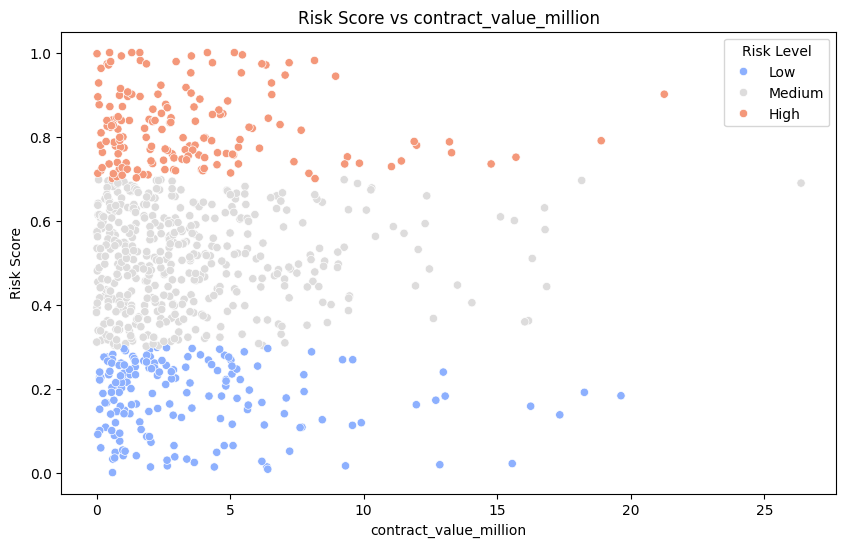

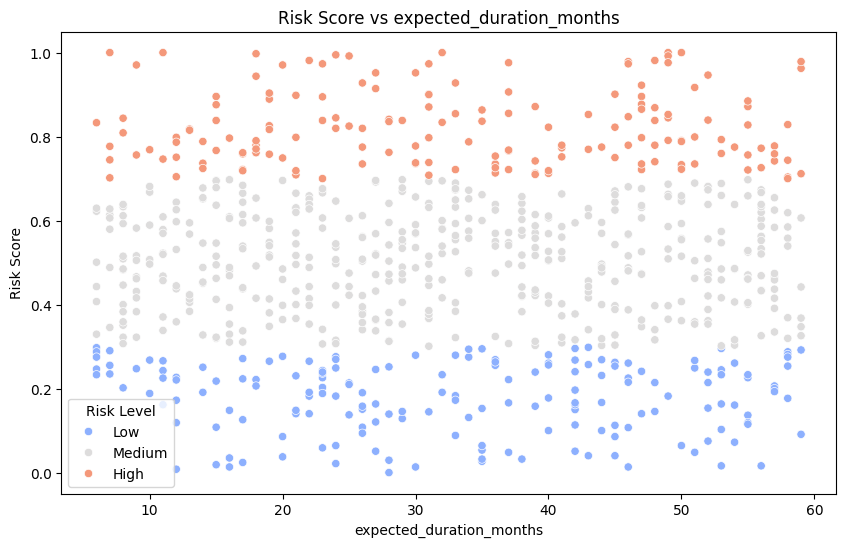

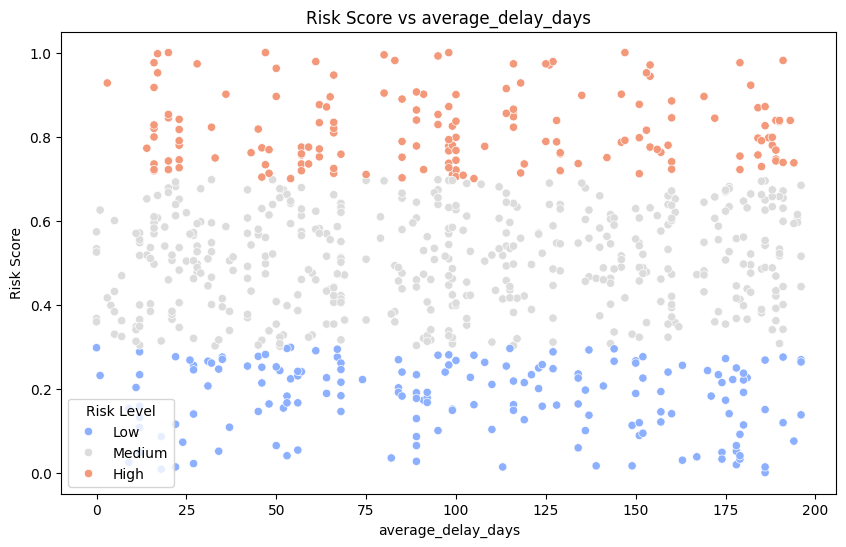

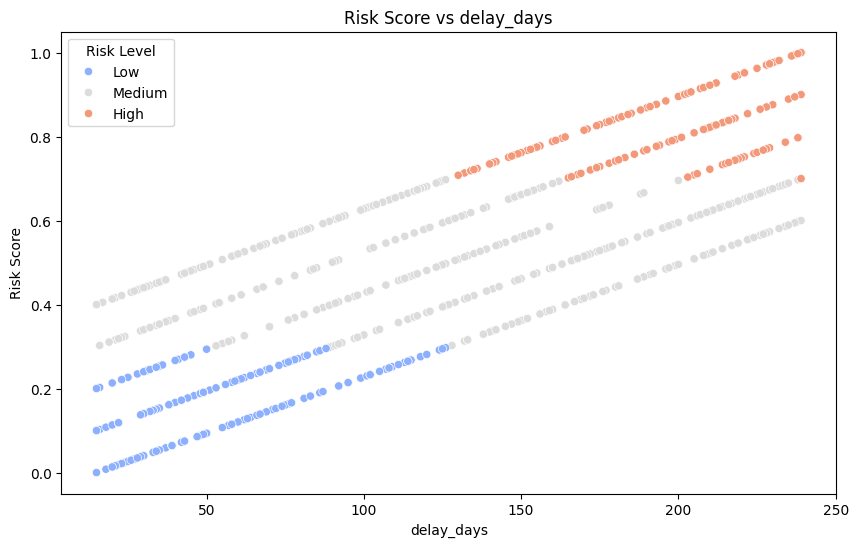

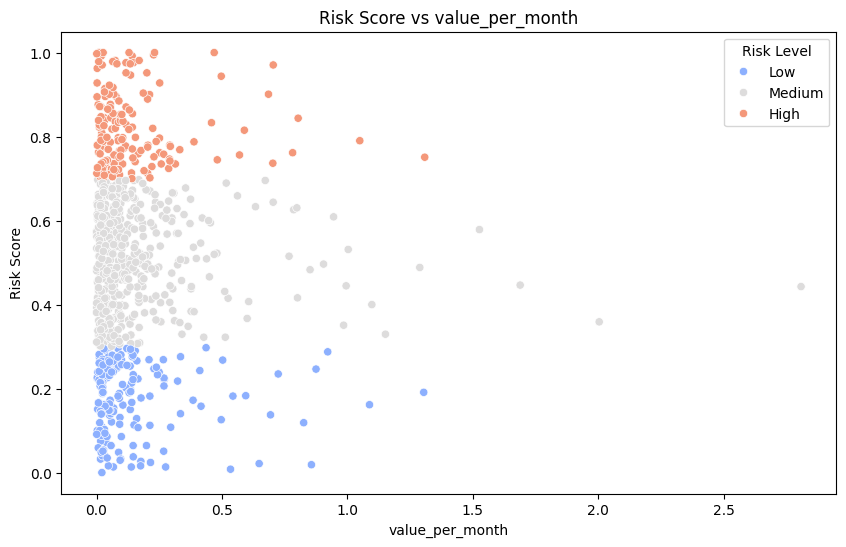

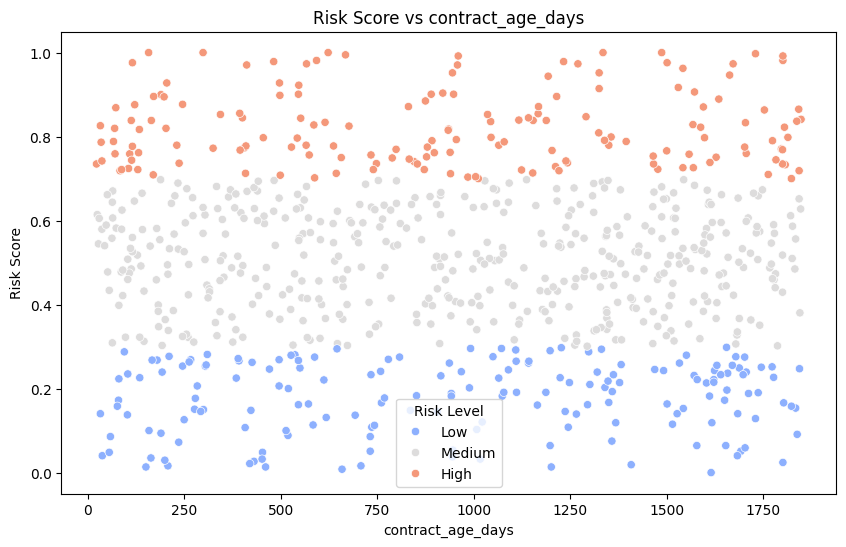

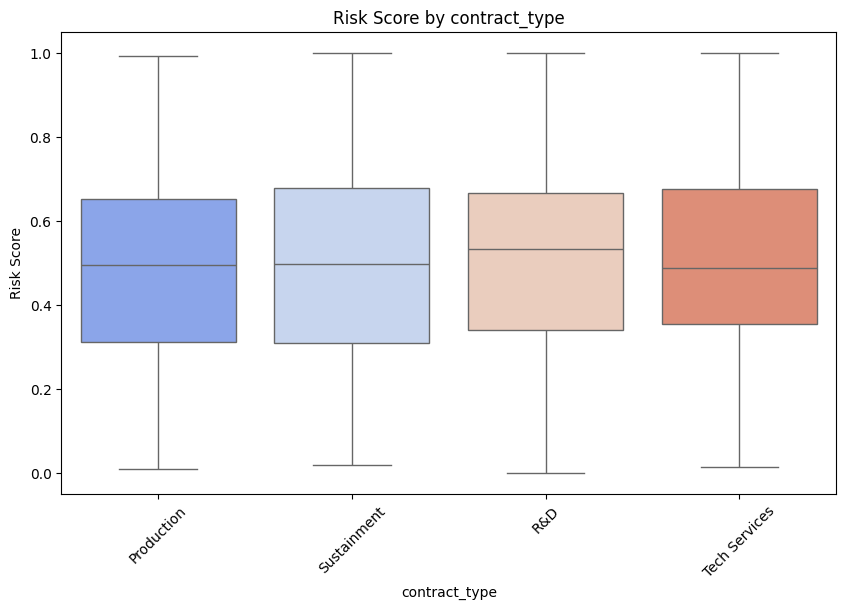

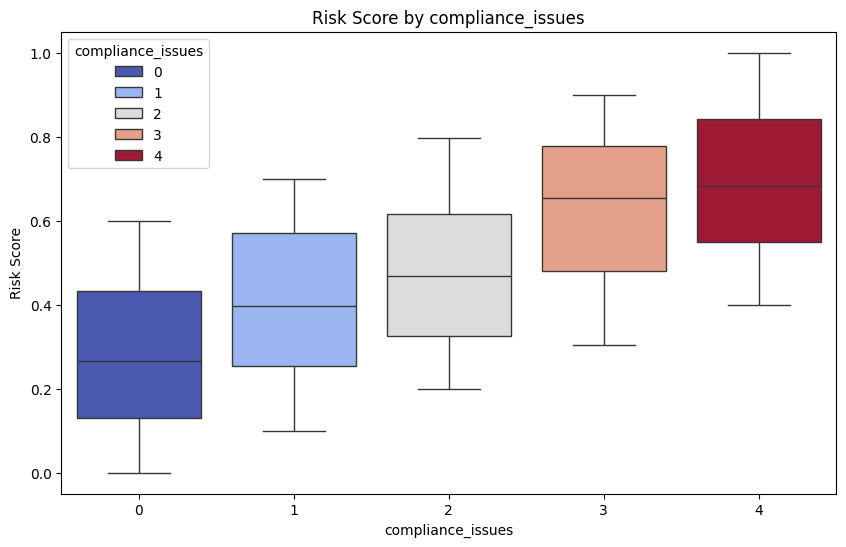

In [38]:
# Risk score vs. Numeric features
for col in numerical_cols:
	if col != 'risk_score':
		plt.figure(figsize=(10, 6))
		sns.scatterplot(data=merged_df, x=col, y='risk_score', hue='risk_level', palette='coolwarm')
		plt.title(f'Risk Score vs {col}')
		plt.xlabel(col)
		plt.ylabel('Risk Score')
		plt.legend(title='Risk Level')
		plt.show()

# Risk score vs. Categorical features
for col in categorical_cols:
	if col != 'risk_level':
		plt.figure(figsize=(10, 6))
		sns.boxplot(data=merged_df, x=col, y='risk_score', hue=col, palette='coolwarm')
		plt.title(f'Risk Score by {col}')
		plt.xlabel(col)
		plt.ylabel('Risk Score')
		if col == 'contract_type':
			plt.xticks(rotation=45)
		plt.show()